# Problem Description

This notebook is based on the work I did in a coding interview. I was tasked with creating a simple machine learning model for a time series.

Specfically, this notebook was created to predict how many incidents of vandalism and verbal disputes occurred daily as reported to the Boston police department. I trained a model on a given dataset and used this to predict future daily number of these incidents.

## Explanation

__Method:__
My approach was to first capture a baseline trend via an ARIMA model fit via a gridsearch, then model the detrended data with two very different machine learning methods. I then ensembled the machine learning models based on a ridge regression and added that back into the baseline trend.

__Validation:__
The ARIMA model was chosen to minimize BIC (Bayesian Information Criterion), which helped to control overfitting. The other methods are validated via Walk Forward Validation or a close approximation. This process respects the _past_ and _future_ aspect of the time series and most closely optimizes the kind of problem that the model will be used for (short-term future prediction).

__Features:__
To pick features and reduce the data, I used only the data rows associated with verbal disputes and vandalism. After that, I removed redundant, spurious, and large categorical columns. I also removed categorical columns with very small sample sizes among the different categories. Finally, I used the feature importances given by an AdaBoost random forest.

The code for all of this is included below. After that I have included several graphs and brief explanations. Note that I have not included anything accounting for the shock associated with COVID-19.

## Code

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.ensemble import AdaBoostRegressor as abr
import xgboost as xgb

#For presentation purposes
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Data Loading and Paring
df = pd.read_csv('tmpwo078bva.csv')
df['OCCURRED_ON_DATE']=pd.to_datetime(df.OCCURRED_ON_DATE)
df.sort_values(by=['OCCURRED_ON_DATE'],inplace=True)

df_verb = df[df.OFFENSE_DESCRIPTION == 'VERBAL DISPUTE']
df_vand = df[df.OFFENSE_DESCRIPTION == 'VANDALISM']

df_verb = df_verb[['YEAR', 'MONTH', 'DAY_OF_WEEK', 'OCCURRED_ON_DATE']]
df_vand = df_vand[['YEAR', 'MONTH', 'DAY_OF_WEEK', 'OCCURRED_ON_DATE']]

df_verb = pd.get_dummies(df_verb,columns=['YEAR', 'MONTH', 'DAY_OF_WEEK'])
df_vand = pd.get_dummies(df_vand,columns=['YEAR', 'MONTH', 'DAY_OF_WEEK'])

groups_verb = df_verb.set_index('OCCURRED_ON_DATE').groupby(pd.Grouper(freq='D'))
groups_vand = df_vand.set_index('OCCURRED_ON_DATE').groupby(pd.Grouper(freq='D'))

#### ARIMA Model

In [3]:
#Find Good Parameters for ARIMA Model
def arima_grid_search(data, width = 5):
    
    best_tup = (0,0,0)
    best_bic = np.inf
    
    for p in range(width):
        for d in range(width):
            for q in range(width):
                try:
                    model = sm.tsa.ARIMA(data,(p,d,q))
                    bic = model.fit().bic
                    if bic < best_bic:
                        best_bic = bic
                        best_tup = (p,d,q)
                except:
                    pass
    
    return best_tup

In [4]:
#ARIMA Information for Verbal Dispute
stat_data_verb = groups_verb.count().YEAR_2015
order_params = arima_grid_search(stat_data_verb,3)
arima_model = sm.tsa.ARIMA(stat_data_verb,order_params)
fit_params = arima_model.fit().params
predictions_arima_verb = arima_model.predict(fit_params, start = stat_data_verb.index[-1]+1,
                                             end = stat_data_verb.index[-1]+35, typ = 'levels')

trend_verb = arima_model.predict(fit_params, start = stat_data_verb.index[0]+1,
                                      end = stat_data_verb.index[-1], typ = 'levels')

#ARIMA Information for Vandalism
stat_data_vand = groups_vand.count().YEAR_2015
order_params = arima_grid_search(stat_data_vand,3)
arima_model = sm.tsa.ARIMA(stat_data_vand,order_params)
fit_params = arima_model.fit().params
predictions_arima_vand = arima_model.predict(fit_params, start = stat_data_vand.index[-1]+1,
                                             end = stat_data_vand.index[-1]+35, typ = 'levels')

trend_vand = arima_model.predict(fit_params, start = stat_data_vand.index[0]+1,
                                      end = stat_data_vand.index[-1], typ = 'levels')

detrended_verb = stat_data_verb[1:] - trend_verb
detrended_vand = stat_data_vand[1:] - trend_vand

#### Feature Selection

In [5]:
df_full_verb = groups_verb.mean()[1:]
df_full_vand = groups_vand.mean()[1:]

y_verb = detrended_verb
y_vand = detrended_vand

In [6]:
#Feature Selection for Verbal Dispute
abr_verb = abr()
abr_verb.fit(df_full_verb,y_verb)
fi_verb = abr_verb.feature_importances_
X_verb = df_full_verb[[df_full_verb.columns[i] for i in range(df_full_verb.shape[1])
                             if fi_verb[i] > 0]]

In [7]:
#Feature Selection for Vandalism
abr_vand = abr()
abr_vand.fit(df_full_vand,y_vand)
fi_vand = abr_vand.feature_importances_
X_vand = df_full_vand[[df_full_vand.columns[i] for i in range(df_full_vand.shape[1])
                             if fi_vand[i] > 0]]

In [8]:
#Create Future Dataset
zero_row = df_full_vand.iloc[0]-df_full_vand.iloc[0]

index_future = stat_data_vand.index[-35:]+35
                        
year_future = index_future.year.values
month_future = index_future.month.values
day_future = index_future.dayofweek.values
days = ['Monday','Tuesday','Wednesday','Thursday',
        'Friday','Saturday','Sunday']

rows = []

for i in range(len(index_future)):
    current_row = zero_row.copy()
    current_row.rename(index_future[i],inplace=True)
    
    current_row['YEAR_'+str(year_future[i])] = 1
    current_row['MONTH_'+str(month_future[i])] = 1
    current_row['DAY_OF_WEEK_'+str(days[day_future[i]])] = 1
    
    rows.append(current_row)

X_future = pd.DataFrame(rows)
X_future_verb = X_future[[df_full_verb.columns[i] for i in range(df_full_verb.shape[1])
                             if fi_verb[i] > 0]]
X_future_vand = X_future[[df_full_vand.columns[i] for i in range(df_full_vand.shape[1])
                             if fi_vand[i] > 0]]

#### Machine Learning Models and Ensemble

In [9]:
def walk_forward_expanding(data, y, model, n_min):
    preds = []
    true_vals = y.values[n_min:]
    
    model.partial_fit(data.values[:n_min],y.values[:n_min])
    
    for i in range(n_min, data.shape[0]):
        preds.append(model.predict([data.values[i]]))
        model.partial_fit([data.values[i]], [y.values[i]])
   
    return preds, r2_score(true_vals,np.array(preds))

In [10]:
def sgd_grid_search(data, y, iters, etas, ts):
    best_score = -1
    b_it, b_eta, b_t = (None, None, None)
    
    for it in iters:
        for eta in etas:
            for t in ts:
                preds, score = walk_forward_expanding(X_verb,y_verb,
                           SGDRegressor(penalty = 'elasticnet', n_iter=it, eta0=eta, power_t=t),
                                                          500)
                if score > best_score:
                    best_score = score
                    b_it, b_eta, b_t = (it,eta,t)
                    
    return preds, b_it, b_eta, b_t

In [11]:
#Model1 Info for Verbal Dispute
test_preds1_verb, it_verb,eta_verb,t_verb = sgd_grid_search(X_verb,y_verb,[2,5,10],[.001,.01,.1],[.1,.25,.5,1])

model1_verb = SGDRegressor(penalty = 'elasticnet', n_iter=it_verb, eta0=eta_verb, power_t=t_verb)
model1_verb.fit(X_verb,y_verb)
model1_verb_preds = model1_verb.predict(X_future_verb)

#Model1 Info for Vandalism
test_preds1_vand, it_vand,eta_vand,t_vand = sgd_grid_search(X_verb,y_verb,[2,5,10],[.001,.01,.1],[.1,.25,.5,1])

model1_vand = SGDRegressor(penalty = 'elasticnet', n_iter=it_vand, eta0=eta_vand, power_t=t_vand)
model1_vand.fit(X_vand,y_vand)
model1_vand_preds = model1_vand.predict(X_future_vand)

In [12]:
def xgb_grid_search(data, y, lr, future):
    initial_train_size = 500
    test_size = 50

    scores = []
    preds_all = []
    
    for rate in lr:
        preds = []
        incr_model = xgb.XGBRegressor(learning_rate = rate, n_jobs = -1)
        incr_model.fit(data.values[:initial_train_size],
                       y.values[:initial_train_size])
        booster = incr_model.get_booster()

        for i in range(data.shape[0]-initial_train_size):
            
            if i == data.shape[0]-initial_train_size-test_size:
                scores.append(incr_model.score(data.values[-test_size:],y.values[-test_size:],
                              sample_weight = .9**np.array(range(test_size))))
                
            preds.append(incr_model.predict([data.values[initial_train_size+i]]))  

            if i < data.shape[0]-initial_train_size - 1:
                incr_model.fit([data.values[initial_train_size+i]],
                               [y.values[initial_train_size+i]],
                               xgb_model = booster, 
                               eval_set = [[[data.values[initial_train_size+i+1]],
                                            [y.values[initial_train_size+i+1]]]],
                               early_stopping_rounds = 30, verbose=False)

                booster = incr_model.get_booster()
            
        preds.append(incr_model.predict(future.values))
        preds_all.append(preds)

    return preds_all[np.argmax(scores)], lr[np.argmax(scores)]

In [13]:
#Model2 Information for Verbal Dispute
all_preds_verb, lr_verb = xgb_grid_search(X_verb,y_verb,[.01,.1,1],X_future_verb)

In [14]:
#Model2 Information for Vandalism
all_preds_vand, lr_vand = xgb_grid_search(X_vand,y_vand,[.01,.1,1],X_future_vand)

In [15]:
def ensemble(y, test_preds1, test_preds2, preds1, preds2):
    test_preds = np.hstack([test_preds1.reshape(-1,1),test_preds2.reshape(-1,1)])
    preds_in = np.hstack([preds1.reshape(-1,1),preds2.reshape(-1,1)])
    
    ens_model = Ridge()
    ens_model.fit(test_preds, y)
    
    ens_model.predict(preds_in)
    
    return ens_model.predict(preds_in)

In [16]:
#Get and Save Final Predictions
preds_verb = ensemble(y_verb[500:], np.array(test_preds1_verb), np.array(all_preds_verb[:-1]),
                      np.array(model1_verb_preds), np.array(all_preds_verb[-1]))

preds_vand = ensemble(y_vand[500:], np.array(test_preds1_vand), np.array(all_preds_vand[:-1]),
                      np.array(model1_vand_preds), np.array(all_preds_vand[-1]))

output = pd.DataFrame(np.array([preds_verb+predictions_arima_verb,preds_vand+predictions_arima_vand]).T,
                      index = X_future.index, columns = ['VERBAL DISPUTE','VANDALISM'])
output.index.name = 'Date'

output.to_csv('predictions.csv')

## Figures

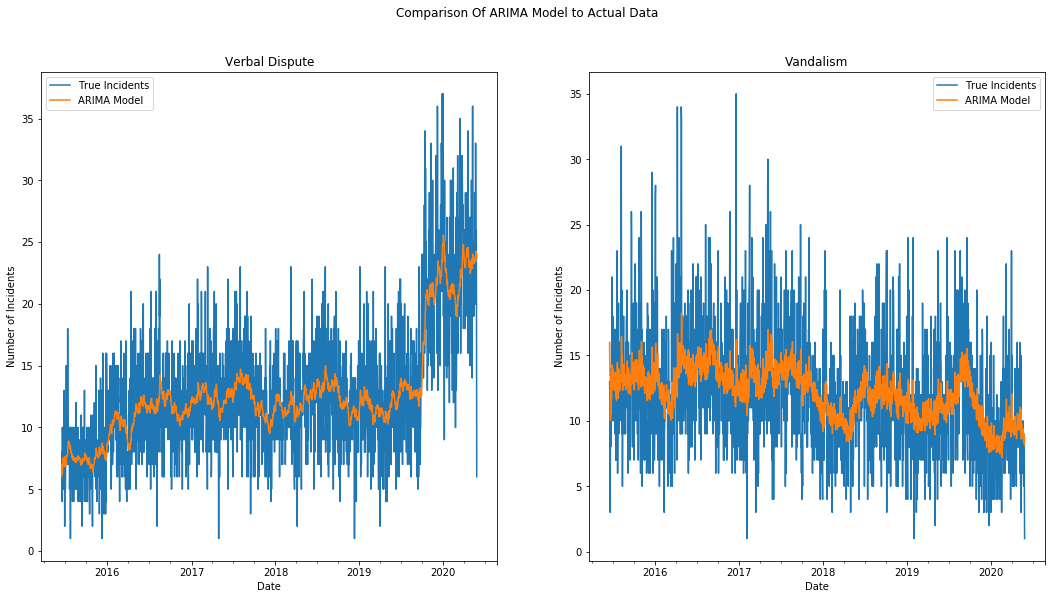

In [17]:
fig = plt.figure(figsize = (18,9))
ax1 = fig.add_subplot(121)

compare_df1 = groups_verb.count().copy()
compare_df1["ARIMA Model"] = np.hstack(([stat_data_verb[0],trend_verb]))
compare_df1["True Incidents"] = compare_df1.YEAR_2015

compare_df1[1:].plot(y=["True Incidents","ARIMA Model"],
                    ax=ax1,title = "Verbal Dispute")
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Incidents')

ax2 = fig.add_subplot(122)

compare_df2 = groups_vand.count().copy()
compare_df2["ARIMA Model"] = np.hstack(([stat_data_vand[0],trend_vand]))
compare_df2["True Incidents"] = compare_df2.YEAR_2015

compare_df2[1:].plot(y=["True Incidents","ARIMA Model"],
                    ax=ax2,title = "Vandalism")
ax2.set_xlabel('Date')
ax2.set_ylabel('Number of Incidents')
plt.suptitle("Comparison Of ARIMA Model to Actual Data")
plt.show()

Here we see that the ARIMA looks like it fits well. This can also be checked by verifying that the detrended data does not show a high degree of seasonality when compared to the original data. Below we check this by looking at the frequency graphs of Verbal Disputes before and after removing the trend.

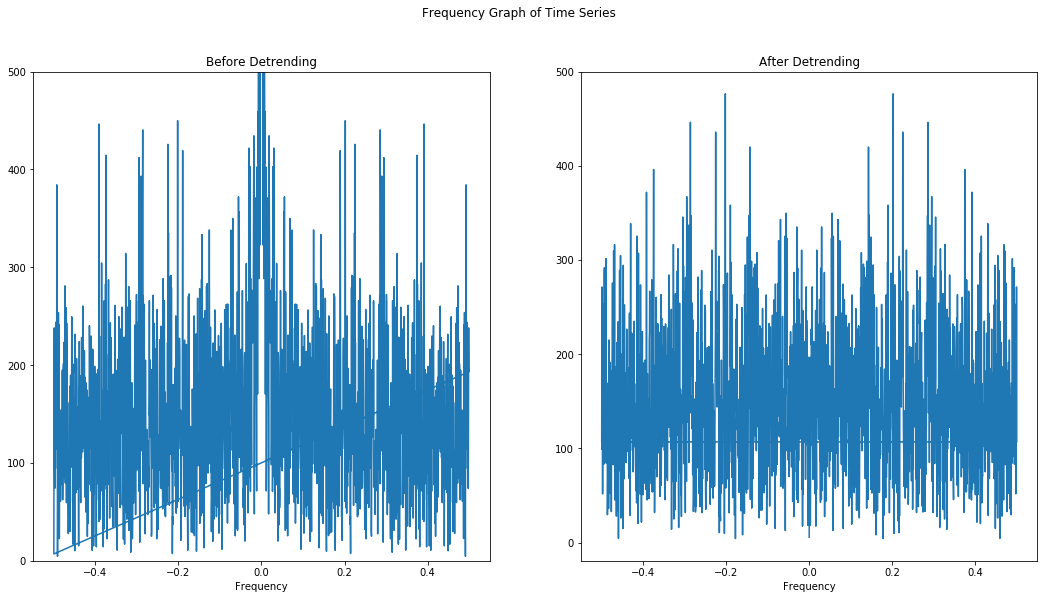

In [18]:
fig = plt.figure(figsize = (18,9))
ax1 = fig.add_subplot(121)

fourier_coeffs = np.fft.fft(stat_data_verb)
freq_vals = np.fft.fftfreq(stat_data_verb.shape[0])
ax1.plot(freq_vals, np.abs(fourier_coeffs))

ax1.set_xlabel('Frequency')
ax1.set_title('Before Detrending')
ax1.set_ylim(0,500)

ax2 = fig.add_subplot(122)

fourier_coeffs = np.fft.fft(detrended_verb)
freq_vals = np.fft.fftfreq(detrended_verb.shape[0])

ax2.set_xlabel('Frequency')
ax2.plot(freq_vals,np.abs(fourier_coeffs))
ax2.set_title('After Detrending')

plt.suptitle('Frequency Graph of Time Series')
plt.show()

Many of the large peaks in the left graph have been taken away. Those that remain are there because we used a model with few parameters in order to avoid overfitting. (Ignore the horizontal lines present in each graph)